In [1]:
from arcgis.gis import GIS
gis = GIS("home")

In [2]:
%matplotlib inline
#ArcGIS packages
import arcpy
#from arcgis.mapping import WebScene
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
from IPython.display import display

from arcgis.features import GeoAccessor
from arcgis import *
from arcpy.sa import Raster, Int  # Raster float to integer
# Raster processing for dataframe
from rasterstats import zonal_stats

# basic packages
import csv
import numpy as np
import os
import timeit
import random
import string
from pprint import pprint
import math

# Data management
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point  # to get points from long lat
import gc
import shutil
import tempfile
import ast
from collections import Counter
from typing import Optional, List

# Request service
#from requests import Request
import json
import re
from functools import reduce
#from owslib.wfs import WebFeatureService

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import export_text
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import warnings
import multiprocessing
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# To save the model and everything else to be API ready
import joblib
import pickle

In [55]:
# Load Drone and Sensor data
drone_df = pd.read_csv("D:/NDIS_Database/rpas_nonan.csv") # Shortlisted verison of RPAS gdb with no NaN data on distance
sensor_df = pd.read_csv("D:/NDIS_Database/sensor.csv") # Geophysical sensor list

# Display the first few rows to verify
drone_df.info()
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             71 non-null     int64  
 1   country             71 non-null     object 
 2   manufacturer        71 non-null     object 
 3   mfc_model           71 non-null     object 
 4   mtow                70 non-null     float64
 5   length              65 non-null     float64
 6   width               66 non-null     float64
 7   height              60 non-null     float64
 8   max_speed           69 non-null     float64
 9   distance_range      71 non-null     int64  
 10  flight_time         70 non-null     float64
 11  max_payload_weight  70 non-null     float64
 12  max_alt             47 non-null     float64
 13  comm_range          62 non-null     float64
 14  power_source        69 non-null     object 
 15  power               59 non-null     object 
 16  gps_accura

In [6]:
# Load geohazard dataset
full_ghz_df = pd.read_csv(r"D:\NDIS_Database\ghz_nuke.csv")
full_ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   economic_loss_million  float64
 8   duration_minutes       float64
 9   HazardStage            object 
 10  haz_stage_key          object 
 11  SurveyOptions          object 
 12  sensor_weight          int64  
 13  PrimarySensor          object 
 14  PrimarySensorWeight    int64  
 15  travel_time            float64
 16  monitor_time           float64
 17  cpm_total_time         float64
dtypes: float64(10), int64(3), object(5)
memory usage: 249.4+ MB


In [56]:
# Clean data
# Clean drone_df to only include relevant columns
drone_df = drone_df[[
    'rpas_id', 'manufacturer', 'mfc_model',
    'distance_range', 'max_payload_weight', 'flight_time', 'comm_range',
    'max_speed', 'mtow', 'length', 'width', 'height',
    'min_op_temp', 'max_op_temp', 'def_payload', 'power_source'
]].dropna(subset=['mfc_model', 'distance_range'])
drone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             71 non-null     int64  
 1   manufacturer        71 non-null     object 
 2   mfc_model           71 non-null     object 
 3   distance_range      71 non-null     int64  
 4   max_payload_weight  70 non-null     float64
 5   flight_time         70 non-null     float64
 6   comm_range          62 non-null     float64
 7   max_speed           69 non-null     float64
 8   mtow                70 non-null     float64
 9   length              65 non-null     float64
 10  width               66 non-null     float64
 11  height              60 non-null     float64
 12  min_op_temp         56 non-null     float64
 13  max_op_temp         55 non-null     float64
 14  def_payload         70 non-null     object 
 15  power_source        69 non-null     object 
dtypes: float64

In [48]:
# Drop unnecessary fields to optimize memory usage
ghz_df = full_ghz_df[[
    'HazardID', 'latitude', 'longitude',
    'HazardType', 'distance', 'pop', 'intensity', 'economic_loss_million', 'duration_minutes',
    'HazardStage', 'haz_stage_key',
    'travel_time', 'monitor_time', 'cpm_total_time'
]].dropna(subset=['HazardID', 'HazardType', 'HazardStage', 'distance'])
ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   economic_loss_million  float64
 8   duration_minutes       float64
 9   HazardStage            object 
 10  haz_stage_key          object 
 11  travel_time            float64
 12  monitor_time           float64
 13  cpm_total_time         float64
dtypes: float64(10), int64(1), object(3)
memory usage: 194.0+ MB


In [20]:
ghz_df.to_csv(r"D:\NDIS_Database\ghz_nuke.csv", index=False)

In [6]:
ghz_df = pd.read_csv(r"D:\NDIS_Database\ghz_nuke.csv")
ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   economic_loss_million  float64
 8   duration_minutes       float64
 9   HazardStage            object 
 10  haz_stage_key          object 
 11  SurveyOptions          object 
 12  sensor_weight          int64  
 13  PrimarySensor          object 
 14  PrimarySensorWeight    int64  
 15  travel_time            float64
 16  monitor_time           float64
 17  cpm_total_time         float64
dtypes: float64(10), int64(3), object(5)
memory usage: 249.4+ MB


## Check Data

In [12]:
len(drone_df.comm_range.unique())

22

In [16]:
drone_df.comm_range.unique()

array([ 15000.,    300.,    500.,   1000.,   2000.,   3000.,  22500.,
         5000.,  16000., 100000.,  10000.,   8000.,   7000.,     nan,
        45000.,   4000.,  20000.,  12000.,  35000.,  40000.,  50000.,
       200000.])

In [14]:
len(drone_df.distance_range.unique())

33

In [15]:
sensor_df

,sensor_id,parameters_measured,s_encoded,sensor_name,sensor_weight,geophysical_method
0,1,velocity,1,Seismic_Sensor,1000,Passive_Seismic
1,2,susceptibility,2,Magnetometers,1500,Magnetic
2,3,conductivity,3,EM_Sensor,3700,Electromagnetic
3,4,density,4,Gravimeter,50000,Gravity
4,5,conductivity,5,GPR_Sensor,3500,GPR
5,6,distance,6,Lidar,900,LiDAR
6,7,spectral,7,Camera,100,Aerial_Imaging
7,8,spectral,8,Hyperspectral_sensors,1900,Hyperspectral
8,9,spectral,9,Multispectral_sensors,350,Multispectral
9,10,temperature,10,Thermal_Camera,830,ThermalIR


In [32]:
drone_usage_counts = count_drone_usage(top3_stat)
drone_usage_counts

ACSL SOTEN                                                1502386
DJI Matrice100                                             989008
MMC Griflion M8                                            376620
AeroSense Aerobo Wing (AS-VT01)                            293157
Aerosonde Ltd AAI Aerosonde Mk 4.3                         269122
Autel Robotics EVO Lite                                     97029
Zhuoyi Droneeye TS-A12                                      59946
DJI Mavic2Pro                                               38169
AgEagle eBee Geo                                            19660
DJI AgrasT16                                                 1840
DJI S900                                                      675
ACSL Fi4                                                      663
ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection        377
Dragandfly Innovations Inc Starling X.2                       122
DJI FlyCart 30                                                112
Dragandfly

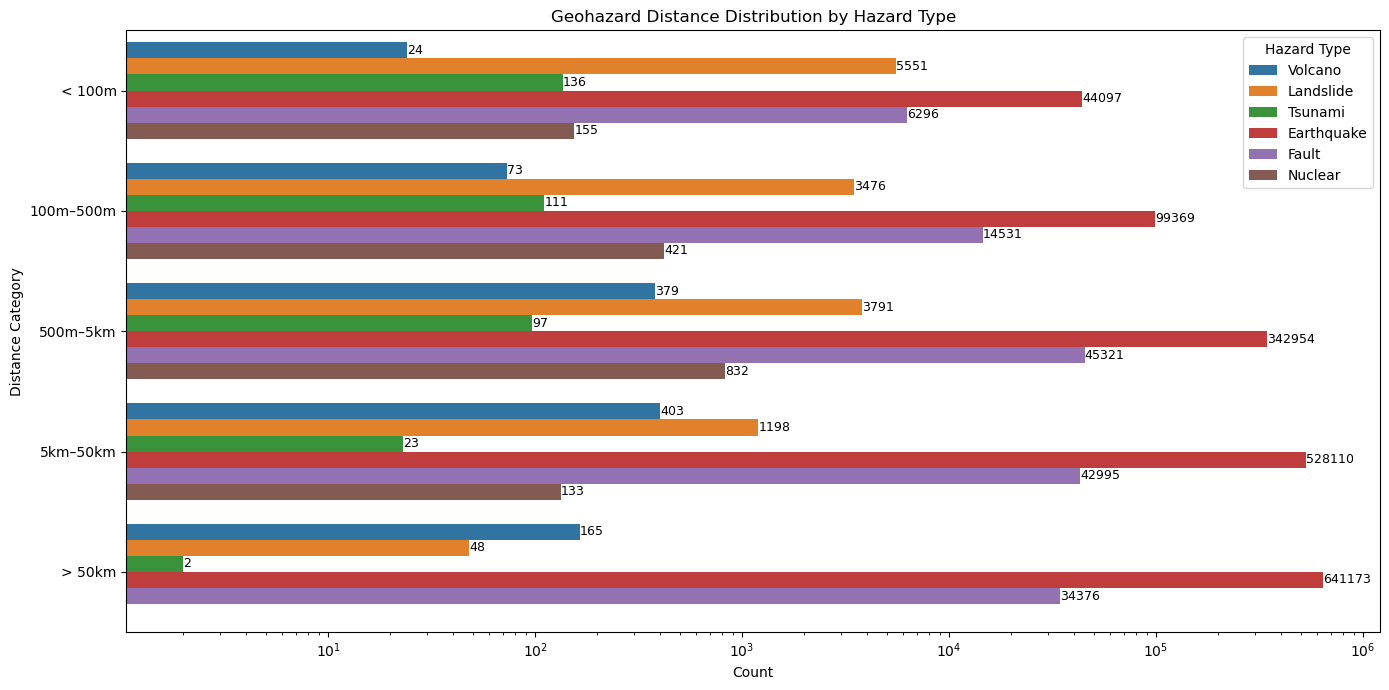

In [11]:
# Categorize distance
def categorize_distance(dist):
    if dist <= 100:
        return "< 100m"
    elif dist <= 500:
        return "100m–500m"
    elif dist <= 5000:
        return "500m–5km"
    elif dist <= 50000:
        return "5km–50km"
    else:
        return "> 50km"

# Apply categorization
ghz_df["distance_cat"] = ghz_df["distance"].apply(categorize_distance)

# Plot
plt.figure(figsize=(14, 7))
ax = sns.countplot(
    data=ghz_df,
    y="distance_cat",
    hue="HazardType",
    order=["< 100m", "100m–500m", "500m–5km", "5km–50km", "> 50km"]
)

# Annotate each bar with the count
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9)
    
plt.title("Geohazard Distance Distribution by Hazard Type")
plt.xlabel("Count")
plt.ylabel("Distance Category")
plt.xscale("log")
plt.legend(title="Hazard Type")
plt.tight_layout()

#plt.savefig(r'D:\NDIS_Database\13_NDIS_Display\ghz_cat_dist.png', dpi=300, transparent=True)
plt.show()

In [12]:
# Count geohazard occurrences per distance category and hazard type
distance_hazard_counts = (
    ghz_df.groupby(["distance_cat", "HazardType"])
    .size()
    .unstack(fill_value=0)
    .loc[["< 100m", "100m–500m", "500m–5km", "5km–50km", "> 50km"]]
)

distance_hazard_counts

HazardType,Earthquake,Fault,Landslide,Nuclear,Tsunami,Volcano
distance_cat,,,,,,
< 100m,44097,6296,5551,155,136,24
100m–500m,99369,14531,3476,421,111,73
500m–5km,342954,45321,3791,832,97,379
5km–50km,528110,42995,1198,133,23,403
> 50km,641173,34376,48,0,2,165


In [17]:
# Find cat for drone and apply categorization
drone_df["distance_cat"] = drone_df["distance_range"].apply(categorize_distance)

C:/Users/Dell/AppData/Local/Temp/ArcGISProTemp9356/xpython_9356/3137411953.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


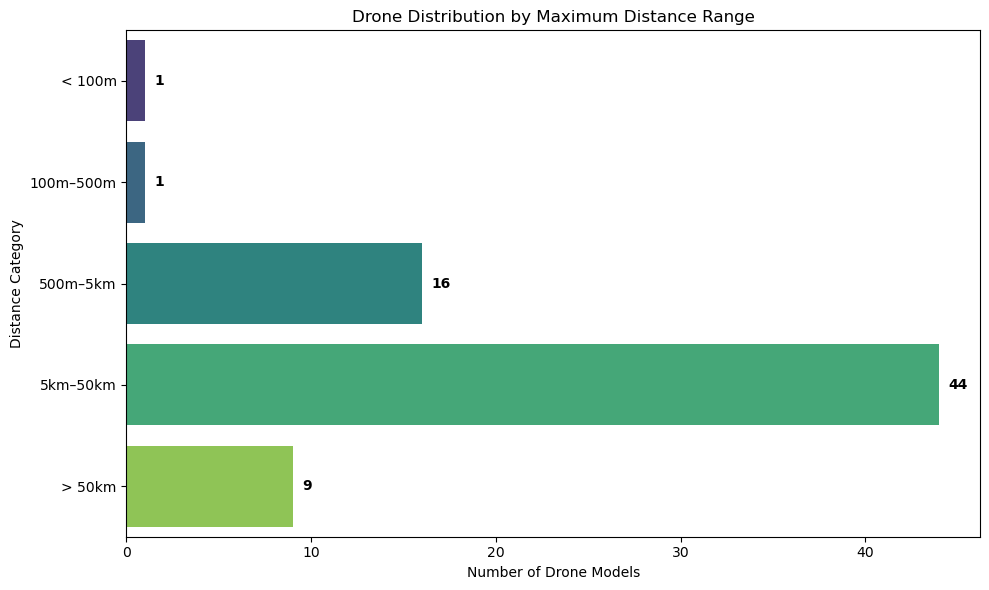

In [18]:
# Count drones in each category
drone_counts = drone_df["distance_cat"].value_counts().reindex(
    ["< 100m", "100m–500m", "500m–5km", "5km–50km", "> 50km"]
)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=drone_counts.values,
    y=drone_counts.index,
    palette="viridis"
)

# Add count labels
for i, val in enumerate(drone_counts.values):
    ax.text(val + 0.5, i, str(val), va='center', fontweight="bold")

plt.title("Drone Distribution by Maximum Distance Range")
plt.xlabel("Number of Drone Models")
plt.ylabel("Distance Category")
plt.tight_layout()
plt.show()

In [23]:
# Categorize each drone by its distance range
def categorize_drone_range(dist):
    if dist <= 100:
        return "< 100m"
    elif dist <= 500:
        return "100m–500m"
    elif dist <= 5000:
        return "500m–5km"
    elif dist <= 50000:
        return "5km–50km"
    else:
        return "> 50km"

drone_df["distance_cat"] = drone_df["distance_range"].apply(categorize_drone_range)

# Count how many drones fall into each category
distance_drone_counts = (
    drone_df["distance_cat"]
    .value_counts()
    .reindex(["< 100m", "100m–500m", "500m–5km", "5km–50km", "> 50km"], fill_value=0)
)

distance_drone_counts


distance_cat
< 100m        1
100m–500m     1
500m–5km     16
5km–50km     44
> 50km        9
Name: count, dtype: int64

In [14]:
ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   economic_loss_million  float64
 8   duration_minutes       float64
 9   HazardStage            object 
 10  haz_stage_key          object 
 11  travel_time            float64
 12  monitor_time           float64
 13  cpm_total_time         float64
dtypes: float64(10), int64(1), object(3)
memory usage: 194.0+ MB


## Map Hazard Stages with the Sensors

## Stage 2&3: Disaster Stage Event Mapping Function

In [78]:
hazard_stage_survey_map = {
    ("Volcano", "pre_event"): ["Magnetometers", "Seismic", "Camera"],
    ("Volcano", "during"): ["Thermal_Camera", "Camera", "Lidar"],
    ("Volcano", "post_event"): ["Lidar", "Camera", "Seismic"],
    ("Volcano", "clean_up"): ["Lidar", "Camera", "Seismic"],

    ("Earthquake", "pre_event"): ["Seismic", "Magnetometers", "Camera"],
    ("Earthquake", "during"): ["Seismic", "Camera", "Lidar"],
    ("Earthquake", "post_event"): ["Lidar", "Camera", "Seismic"],

    ("Fault", "pre_event"): ["Seismic", "Magnetometers", "Camera"],
    ("Fault", "post_event"): ["Seismic", "Camera", "Lidar"],

    ("Landslide", "pre_event"): ["Lidar", "GPR", "Camera"],
    ("Landslide", "during"): ["Camera", "Thermal_Camera", "Lidar"],
    ("Landslide", "post_event"): ["Lidar", "Seismic", "Camera"],
    ("Landslide", "clean_up"): ["Camera", "Lidar", "Seismic"],

    ("Tsunami", "during"): ["Camera", "Thermal_Camera", "Lidar"],
    ("Tsunami", "post_event"): ["Camera", "Lidar", "Seismic"],
    ("Tsunami", "clean_up"): ["Camera", "Lidar", "Seismic"],

    ("Nuclear", "pre_event"): ["Thermal_Camera", "Camera", "Lidar"],
    ("Nuclear", "during"): ["Thermal_Camera", "Camera", "Lidar"],
    ("Nuclear", "post_event"): ["Camera", "Lidar", "Seismic"],
    ("Nuclear", "clean_up"): ["Camera", "Lidar", "Seismic"]
}


In [15]:
camera_included = all("Camera" in sensors for sensors in hazard_stage_survey_map.values())
print("Camera in every mapping:", camera_included)


Camera in every mapping: True


## Stage 4: Drone Selection

In [7]:
# ------------------- v3.6.3 ENGINEERING FLIGHT PATH BASED ON AREA -------------------

# Line spacing rules per sensor type (in meters)
sensor_spacing = {
    "Seismic": None,
    "Magnetometers": 5,
    "Lidar": 10,
    "GPR": None,
    "Camera": 20,
    "Thermal_Camera": 20,
    "Hyperspectral": 20,
    "Multispectral": 20,
    "EM": 10,
    "Gravimeter": 20
}

def compute_mission_flight_distance(sensor_name, hazard_distance, area_length=None, area_width=None):
    """
    Calculates total flight distance based on user area input or hazard_distance fallback.
    """
    # Seismic & GPR remain delivery profile
    if sensor_name == "Seismic":
        return hazard_distance
    elif sensor_name == "GPR":
        return 1000

    # If area input provided, calculate using lawnmower pattern
    if area_length and area_width:
        spacing = sensor_spacing.get(sensor_name, 10)  # default spacing if sensor not found
        if spacing and spacing > 0:
            num_lines = math.ceil(area_width / spacing)
            total_distance = num_lines * area_length
            return total_distance
        else:
            return hazard_distance  # fallback for point sensors
    else:
        # If no area provided → fallback to previous rules
        if sensor_name == "Magnetometers":
            return 20000
        elif sensor_name == "Lidar":
            return math.pi * hazard_distance
        elif sensor_name in ["Camera", "Thermal_Camera"]:
            return hazard_distance
        elif sensor_name in ["Hyperspectral", "Multispectral"]:
            return hazard_distance * 3
        else:
            return hazard_distance


In [8]:
# ------------------- Optional: Apply to batch processing -------------------

for snum in [1, 2, 3]:
    ghz_df370[f"sensor{snum}_flight_path"] = ghz_df370.apply(
        lambda row: compute_mission_flight_distance(
            row[f"sensor{snum}"],
            row["distance"],
            area_length=None,   # <-- leave None for now, or pass user-defined area if available
            area_width=None
        ),
        axis=1
    )


## Functions for API starts HERE!!

In [9]:
# ------------- v3.7.0 Unified Auto-Default Flight Path Calculation for Both API & Batch ---------------

# Default area templates for batch mode (length x width in meters)
sensor_default_area = {
    "Seismic": (None, None),
    "Magnetometers": (500, 200),
    "Lidar": (400, 400),
    "GPR": (None, None),
    "Camera": (300, 300),
    "Thermal_Camera": (300, 300),
    "Hyperspectral": (1000, 200),
    "Multispectral": (1000, 200),
    "EM": (400, 400),
    "Gravimeter": (500, 500)
}

# Line spacing rules per sensor type
sensor_spacing = {
    "Seismic": None,
    "Magnetometers": 5,
    "Lidar": 10,
    "GPR": None,
    "Camera": 20,
    "Thermal_Camera": 20,
    "Hyperspectral": 20,
    "Multispectral": 20,
    "EM": 10,
    "Gravimeter": 20
}

# Unified flight path function for both API & Batch
def compute_mission_flight_distance(sensor_name, hazard_distance, area_length=None, area_width=None):
    if sensor_name == "Seismic":
        return hazard_distance
    elif sensor_name == "GPR":
        return 1000
    
    # If no user input area given → use sensor default template
    if not area_length or not area_width:
        default_area = sensor_default_area.get(sensor_name, (None, None))
        area_length, area_width = default_area

    if area_length and area_width:
        spacing = sensor_spacing.get(sensor_name, 10)
        if spacing and spacing > 0:
            num_lines = math.ceil(area_width / spacing)
            total_distance = num_lines * area_length
            return total_distance
        else:
            return hazard_distance
    else:
        # If still no area defined (non-scanning sensors), fallback to previous simple models
        if sensor_name == "Magnetometers":
            return 20000
        elif sensor_name == "Lidar":
            return math.pi * hazard_distance
        elif sensor_name in ["Camera", "Thermal_Camera"]:
            return hazard_distance
        elif sensor_name in ["Hyperspectral", "Multispectral"]:
            return hazard_distance * 3
        else:
            return hazard_distance


### Batch Processing

# Version 3.7.2 - Adaptive Staggered Decision Engine

In [14]:
# Define bin edges for comm_range and distance_range
comm_range_bins = np.array([300., 500., 1000., 2000., 3000., 4000., 5000., 7000., 8000., 10000.,
  12000., 15000., 16000., 20000., 22500., 35000., 40000., 45000., 50000., 100000., 200000., np.inf])

distance_range_bins = np.array([21, 300, 700, 1000, 2000, 3000, 4000, 5000, 7000, 8000, 10000, 12000,
  15000, 16000, 18000, 20000, 24000, 27000, 30000, 30240, 35000, 40000, 45000, 50000, 52500, 86000,
  104607, 135000, 150000, 190000, 450000, 563000, 1046000, np.inf])

payload_weight_bins = np.array([0.0, 10.0, 230.0, 315.0, 400.0, 450.0, 800.0, 1000.0, 1200.0, 1500.0,
  2000.0, 2200.0, 2340.0, 2700.0, 3000.0, 3100.0, 4000.0, 4700.0, 5000.0, 6000.0, 7500.0, 8000.0,
  8100.0, 9000.0, 10000.0, 16000.0, 20000.0, 25000.0, 30000.0, 158757.0, 226796.0, np.inf])


In [7]:
# ---------------- Default area templates for each sensor - to get Flight Path ------------------

sensor_default_area = {
    "Seismic": (None, None),
    "Magnetometers": (500, 200),
    "Lidar": (400, 400),
    "GPR": (None, None),
    "Camera": (300, 300),
    "Thermal_Camera": (300, 300),
    "Hyperspectral": (1000, 200),
    "Multispectral": (1000, 200),
    "EM": (400, 400),
    "Gravimeter": (500, 500)
}

# Line spacing for flight path estimation
sensor_spacing = {
    "Seismic": None,
    "Magnetometers": 5,
    "Lidar": 10,
    "GPR": None,
    "Camera": 20,
    "Thermal_Camera": 20,
    "Hyperspectral": 20,
    "Multispectral": 20,
    "EM": 10,
    "Gravimeter": 20
}

# Hazard stage
hazard_stage_survey_map = {
    ("Volcano", "pre_event"): ["Magnetometers", "Seismic", "Camera"],
    ("Volcano", "during"): ["Thermal_Camera", "Camera", "Lidar"],
    ("Volcano", "post_event"): ["Lidar", "Camera", "Seismic"],
    ("Volcano", "clean_up"): ["Lidar", "Camera", "Seismic"],

    ("Earthquake", "pre_event"): ["Seismic", "Magnetometers", "Camera"],
    ("Earthquake", "during"): ["Seismic", "Camera", "Lidar"],
    ("Earthquake", "post_event"): ["Lidar", "Camera", "Seismic"],

    ("Fault", "pre_event"): ["Seismic", "Magnetometers", "Camera"],
    ("Fault", "post_event"): ["Seismic", "Camera", "Lidar"],

    ("Landslide", "pre_event"): ["Lidar", "GPR", "Camera"],
    ("Landslide", "during"): ["Camera", "Thermal_Camera", "Lidar"],
    ("Landslide", "post_event"): ["Lidar", "Seismic", "Camera"],
    ("Landslide", "clean_up"): ["Camera", "Lidar", "Seismic"],

    ("Tsunami", "during"): ["Camera", "Thermal_Camera", "Lidar"],
    ("Tsunami", "post_event"): ["Camera", "Lidar", "Seismic"],
    ("Tsunami", "clean_up"): ["Camera", "Lidar", "Seismic"],

    ("Nuclear", "pre_event"): ["Thermal_Camera", "Camera", "Lidar"],
    ("Nuclear", "during"): ["Thermal_Camera", "Camera", "Lidar"],
    ("Nuclear", "post_event"): ["Camera", "Lidar", "Seismic"],
    ("Nuclear", "clean_up"): ["Camera", "Lidar", "Seismic"]
}


In [16]:
# ------------------ Core Helper Functions ----------------------

def get_bin(value, bins):
    return np.digitize(value, bins)

def compute_mission_flight_distance(sensor_name, hazard_distance, area_length=None, area_width=None):
    if sensor_name == "Seismic":
        return hazard_distance
    elif sensor_name == "GPR":
        return 1000

    if area_length and area_width:
        spacing = sensor_spacing.get(sensor_name, 10)
        if spacing and spacing > 0:
            num_lines = math.ceil(area_width / spacing)
            return num_lines * area_length
        else:
            return hazard_distance
    else:
        area_length, area_width = sensor_default_area.get(sensor_name, (None, None))
        if area_length and area_width:
            spacing = sensor_spacing.get(sensor_name, 10)
            num_lines = math.ceil(area_width / spacing)
            return num_lines * area_length
        else:
            if sensor_name == "Magnetometers":
                return 20000
            elif sensor_name == "Lidar":
                return math.pi * hazard_distance
            elif sensor_name in ["Camera", "Thermal_Camera"]:
                return hazard_distance
            elif sensor_name in ["Hyperspectral", "Multispectral"]:
                return hazard_distance * 3
            else:
                return hazard_distance


In [20]:
# ghz_df = full geohazard dataframe (+-1.9M rows)
# sensor_df = sensor weight table
# drone_df = drone specifications table
start = timeit.default_timer()

results372_df = full_mission_recommender_batch_chunked(ghz_df370, sensor_df, drone_df, chunk_size=50000)

# Export result if needed
#results_df.to_csv("v3.8.0_geohazard_drone_results.csv", index=False)

elapsed = timeit.default_timer() - start
print(f"\u2705 Batch Processing Done! Time: {elapsed / 60:.2f} minutes")

🍳 Processing rows 0 to 50000...
🍳 Processing rows 50000 to 100000...
🍳 Processing rows 100000 to 150000...
🍳 Processing rows 150000 to 200000...
🍳 Processing rows 200000 to 250000...
🍳 Processing rows 250000 to 300000...
🍳 Processing rows 300000 to 350000...
🍳 Processing rows 350000 to 400000...
🍳 Processing rows 400000 to 450000...
🍳 Processing rows 450000 to 500000...
🍳 Processing rows 500000 to 550000...
🍳 Processing rows 550000 to 600000...
🍳 Processing rows 600000 to 650000...
🍳 Processing rows 650000 to 700000...
🍳 Processing rows 700000 to 750000...
🍳 Processing rows 750000 to 800000...
🍳 Processing rows 800000 to 850000...
🍳 Processing rows 850000 to 900000...
🍳 Processing rows 900000 to 950000...
🍳 Processing rows 950000 to 1000000...
🍳 Processing rows 1000000 to 1050000...
🍳 Processing rows 1050000 to 1100000...
🍳 Processing rows 1100000 to 1150000...
🍳 Processing rows 1150000 to 1200000...
🍳 Processing rows 1200000 to 1250000...
🍳 Processing rows 1250000 to 1300000...
🍳 Proc

In [22]:
results372_df.to_csv(r"D:\NDIS_Database\NDIS372_geohazard_drone_results.csv", index=False)

In [11]:
results372_df

,HazardID,HazardType,Stage,Sensor,FlightPath_m,DroneRank,DroneModel,PayloadOverkill,DistanceOverkill,PayloadWeight,DistanceRange,CommRange,FlightTime
0,210010,Volcano,during,Thermal_Camera,4500.0,1,DJI Matrice100,170.0,500.0,1000.0,5000,5000.0,40.0
1,210010,Volcano,during,Thermal_Camera,4500.0,2,EAMS E484MP,2170.0,500.0,3000.0,4000,1000.0,20.0
2,210010,Volcano,during,Thermal_Camera,4500.0,3,JTT Spider C85,1170.0,2500.0,2000.0,7000,7000.0,40.0
3,210010,Volcano,during,Camera,4500.0,1,DJI Mavic Mini,100.0,500.0,0.0,4000,2000.0,30.0
4,210010,Volcano,during,Camera,4500.0,2,Parrot ANAFIAi,100.0,500.0,0.0,4000,22500.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16346155,111100000501496,Nuclear,pre_event,Camera,4500.0,2,Parrot ANAFIAi,100.0,500.0,0.0,4000,22500.0,32.0
16346156,111100000501496,Nuclear,pre_event,Camera,4500.0,3,AEE Aviation Technology MACH4-5G,300.0,500.0,400.0,5000,100000.0,30.0
16346157,111100000501496,Nuclear,pre_event,Lidar,16000.0,1,Acecore Zetona 8,1300.0,0.0,2200.0,16000,16000.0,26.0
16346158,111100000501496,Nuclear,pre_event,Lidar,16000.0,2,Aerialtronics Altura Zenith ATX8,2100.0,2000.0,3000.0,18000,1000.0,40.0


In [8]:
results372_df.DroneModel.unique()

array(['DJI Matrice100', 'EAMS E484MP', 'JTT Spider C85',
       'DJI Mavic Mini', 'Parrot ANAFIAi',
       'AEE Aviation Technology MACH4-5G', 'Acecore Zetona 8',
       'Aerialtronics Altura Zenith ATX8', 'Acecore Noa H6 Hybrid',
       'ACSL AirTruck', 'Dragandfly Innovations Inc Starling X.2',
       'DJI S900', 'IDEAFLY Poseidon-480 Pro II', 'IDEAFLY Thor-850',
       'AEE Aviation Technology G10',
       'Aerosonde Ltd AAI Aerosonde Mk 4.3', 'JOUAV CW-15',
       'DJI Matrice200SeriesV2', 'AeroSense Aerobo Wing (AS-VT01)',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'Freespace Operation Callisto 50 Multirotor', 'DJI Matrice200V2',
       'Garuda Robotics Cerana ONE Pro', 'MMC Griflion M8',
       'DJI Matrice300RTK', 'Acecore Zoe X4', 'DJI Matrice210V2',
       'DJI FlyCart 30', 'Dragandfly Innovations Inc Heavy Lift Drone'],
      dtype=object)

In [40]:
results372_df = pd.read_csv(r"D:\NDIS_Database\NDIS372_geohazard_drone_results.csv")
results372_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   HazardID          int64  
 1   HazardType        object 
 2   Stage             object 
 3   Sensor            object 
 4   FlightPath_m      float64
 5   DroneRank         int64  
 6   DroneModel        object 
 7   PayloadOverkill   float64
 8   DistanceOverkill  float64
 9   PayloadWeight     float64
 10  DistanceRange     int64  
 11  CommRange         float64
 12  FlightTime        float64
dtypes: float64(6), int64(3), object(4)
memory usage: 1.6+ GB


In [43]:
results372_df

,HazardID,HazardType,Stage,Sensor,FlightPath_m,DroneRank,DroneModel,PayloadOverkill,DistanceOverkill,PayloadWeight,DistanceRange,CommRange,FlightTime
0,210010,Volcano,during,Thermal_Camera,4500.0,1,DJI Matrice100,170.0,500.0,1000.0,5000,5000.0,40.0
1,210010,Volcano,during,Thermal_Camera,4500.0,2,EAMS E484MP,2170.0,500.0,3000.0,4000,1000.0,20.0
2,210010,Volcano,during,Thermal_Camera,4500.0,3,JTT Spider C85,1170.0,2500.0,2000.0,7000,7000.0,40.0
3,210010,Volcano,during,Camera,4500.0,1,DJI Mavic Mini,100.0,500.0,0.0,4000,2000.0,30.0
4,210010,Volcano,during,Camera,4500.0,2,Parrot ANAFIAi,100.0,500.0,0.0,4000,22500.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16346155,111100000501496,Nuclear,pre_event,Camera,4500.0,2,Parrot ANAFIAi,100.0,500.0,0.0,4000,22500.0,32.0
16346156,111100000501496,Nuclear,pre_event,Camera,4500.0,3,AEE Aviation Technology MACH4-5G,300.0,500.0,400.0,5000,100000.0,30.0
16346157,111100000501496,Nuclear,pre_event,Lidar,16000.0,1,Acecore Zetona 8,1300.0,0.0,2200.0,16000,16000.0,26.0
16346158,111100000501496,Nuclear,pre_event,Lidar,16000.0,2,Aerialtronics Altura Zenith ATX8,2100.0,2000.0,3000.0,18000,1000.0,40.0


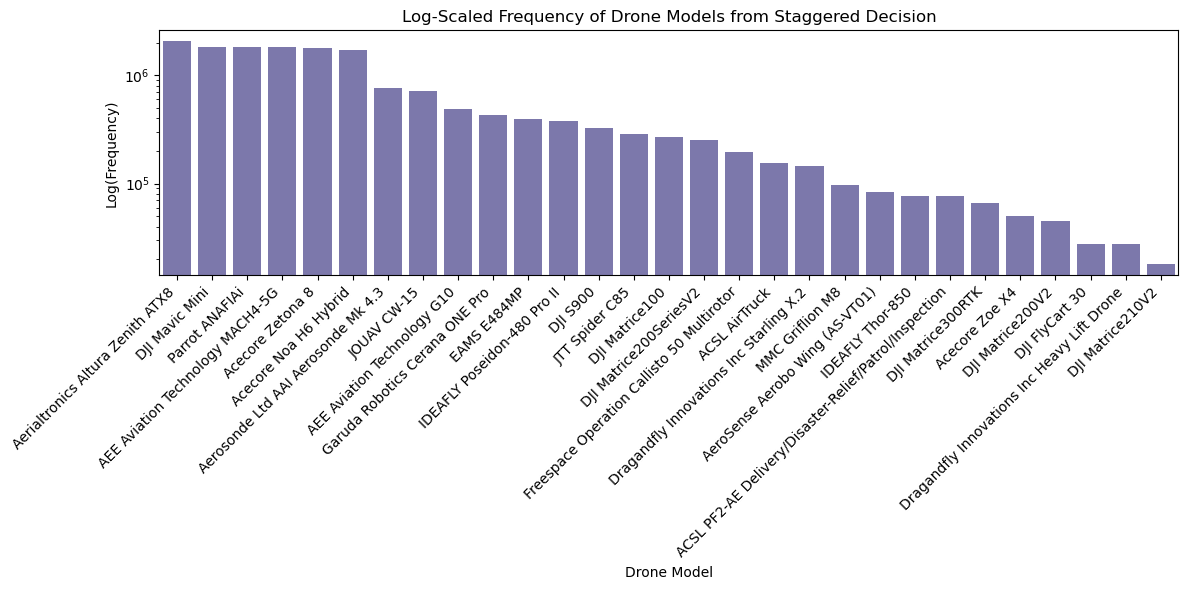

In [47]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=results372_df,
    x='DroneModel',
    order=results372_df['DroneModel'].value_counts().index,
    color='#7570b3'
)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Drone Model")
plt.ylabel("Log(Frequency)")
plt.title("Log-Scaled Frequency of Drone Models from Staggered Decision")
plt.tight_layout()
plt.savefig(r'D:\NDIS_Database\16_Paper\drone_staggeredresult.png', dpi=300, transparent=True)
plt.show()

In [51]:
results372_df['DroneModel'].value_counts().index

Index(['Aerialtronics Altura Zenith ATX8', 'DJI Mavic Mini', 'Parrot ANAFIAi',
       'AEE Aviation Technology MACH4-5G', 'Acecore Zetona 8',
       'Acecore Noa H6 Hybrid', 'Aerosonde Ltd AAI Aerosonde Mk 4.3',
       'JOUAV CW-15', 'AEE Aviation Technology G10',
       'Garuda Robotics Cerana ONE Pro', 'EAMS E484MP',
       'IDEAFLY Poseidon-480 Pro II', 'DJI S900', 'JTT Spider C85',
       'DJI Matrice100', 'DJI Matrice200SeriesV2',
       'Freespace Operation Callisto 50 Multirotor', 'ACSL AirTruck',
       'Dragandfly Innovations Inc Starling X.2', 'MMC Griflion M8',
       'AeroSense Aerobo Wing (AS-VT01)', 'IDEAFLY Thor-850',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'DJI Matrice300RTK', 'Acecore Zoe X4', 'DJI Matrice200V2',
       'DJI FlyCart 30', 'Dragandfly Innovations Inc Heavy Lift Drone',
       'DJI Matrice210V2'],
      dtype='object', name='DroneModel')

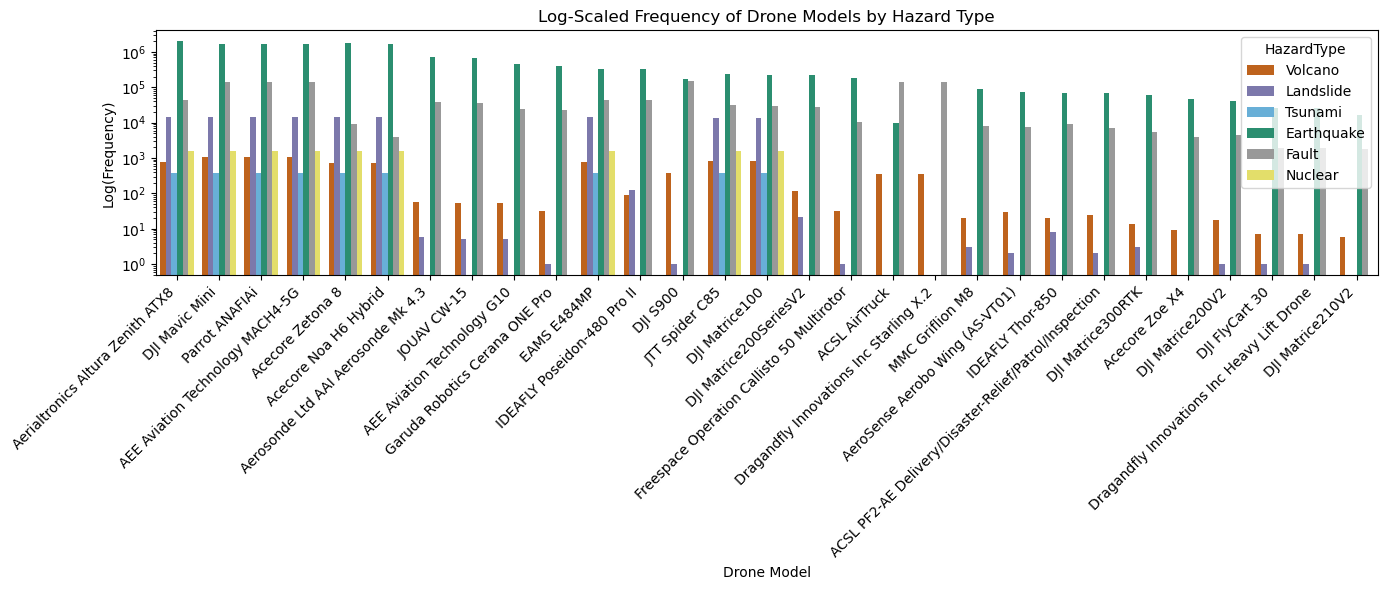

In [49]:
# Define custom color palette
color_map = {
    'Volcano': '#d95f02',
    'Earthquake': '#1b9e77',
    'Landslide': '#7570b3',
    'Tsunami': '#56B4E9',
    'Fault': '#999999',
    'Nuclear': '#f7f056'
}


plt.figure(figsize=(14, 6))
sns.countplot(
    data=results372_df,
    x='DroneModel',
    hue='HazardType',
    order=results372_df['DroneModel'].value_counts().index,
    palette=color_map
)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Drone Model")
plt.ylabel("Log(Frequency)")
plt.title("Log-Scaled Frequency of Drone Models by Hazard Type")
plt.tight_layout()
plt.show()

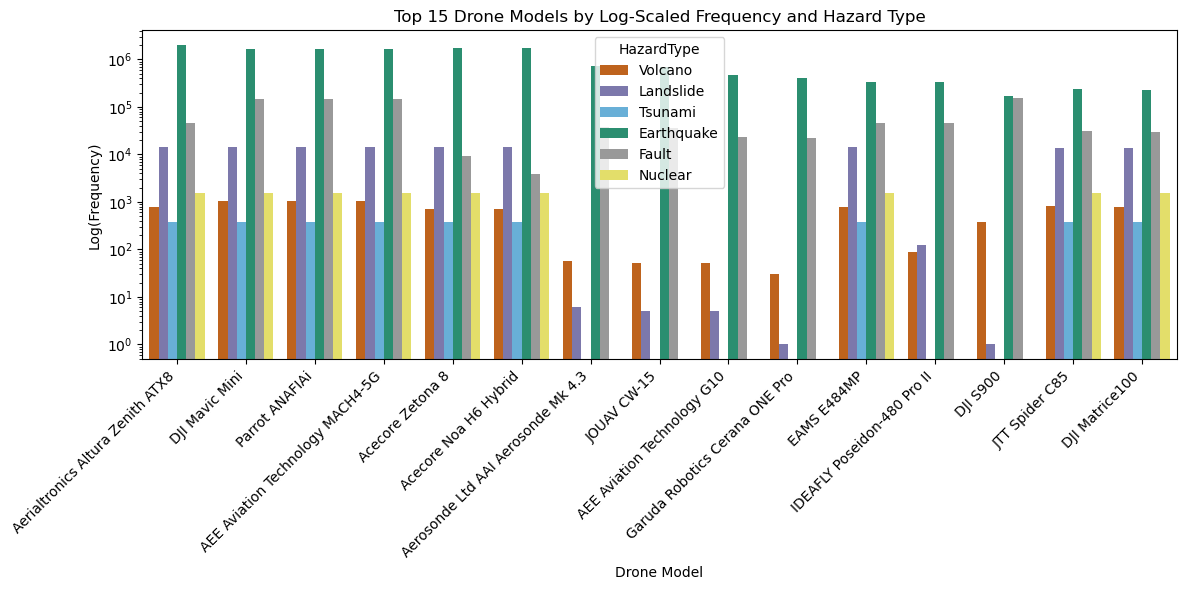

In [50]:
# Get top 15 most frequent DroneModels
top_models = results372_df['DroneModel'].value_counts().nlargest(15).index

plt.figure(figsize=(12, 6))
sns.countplot(
    data=results372_df[results372_df['DroneModel'].isin(top_models)],
    x='DroneModel',
    hue='HazardType',
    order=top_models,
    palette=color_map
)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Drone Model")
plt.ylabel("Log(Frequency)")
plt.title("Top 15 Drone Models by Log-Scaled Frequency and Hazard Type")
plt.tight_layout()
plt.savefig(r'D:\NDIS_Database\16_Paper\staggeredresult.png', dpi=300, transparent=True)
plt.show()

In [61]:
top_models

Index(['Aerialtronics Altura Zenith ATX8', 'DJI Mavic Mini', 'Parrot ANAFIAi',
       'AEE Aviation Technology MACH4-5G', 'Acecore Zetona 8',
       'Acecore Noa H6 Hybrid', 'Aerosonde Ltd AAI Aerosonde Mk 4.3',
       'JOUAV CW-15', 'AEE Aviation Technology G10',
       'Garuda Robotics Cerana ONE Pro', 'EAMS E484MP',
       'IDEAFLY Poseidon-480 Pro II', 'DJI S900', 'JTT Spider C85',
       'DJI Matrice100'],
      dtype='object', name='DroneModel')

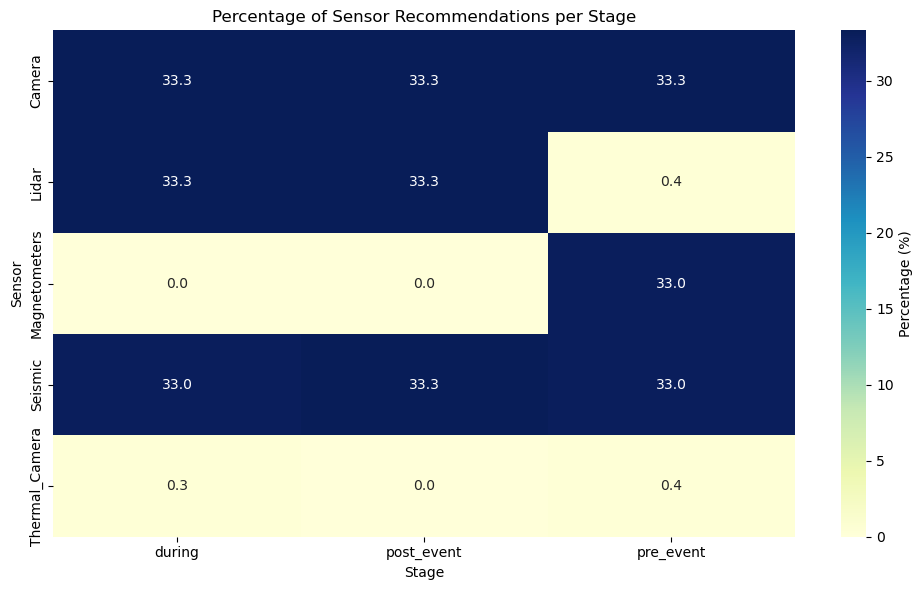

In [52]:
# Create crosstab of Sensor vs Stage with counts
sensor_stage_ct = pd.crosstab(results372_df['Sensor'], results372_df['Stage'], normalize='columns') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(sensor_stage_ct, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Percentage (%)'})
plt.xlabel("Stage")
plt.ylabel("Sensor")
plt.title("Percentage of Sensor Recommendations per Stage")
plt.tight_layout()
plt.show()

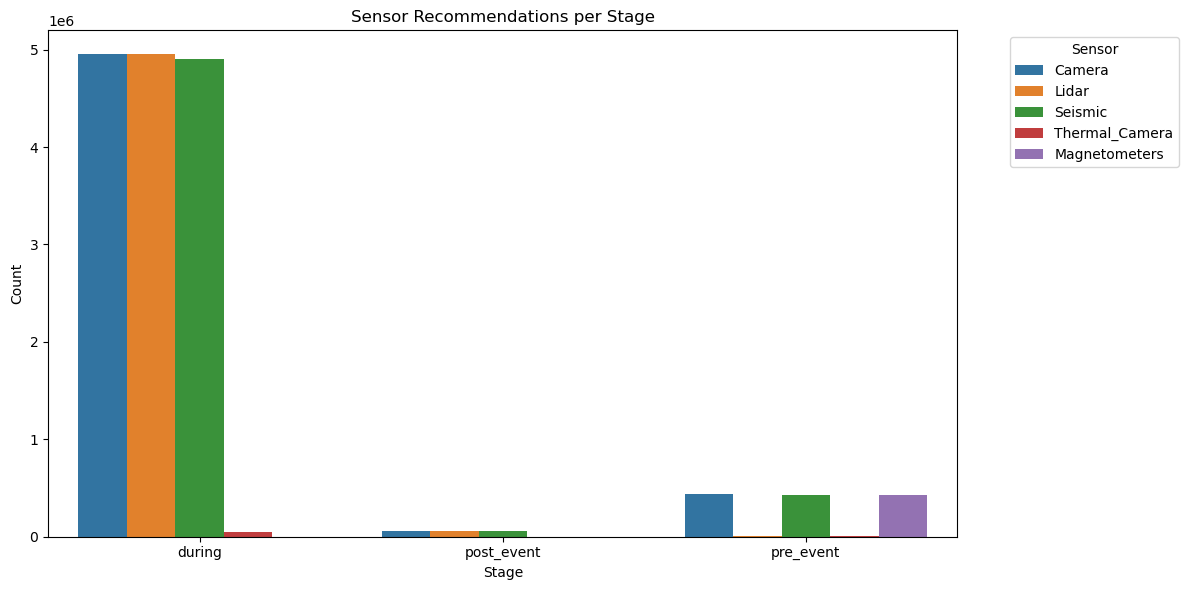

In [53]:
# Count occurrences of each (Sensor, Stage) pair
sensor_stage_counts = results372_df.groupby(['Stage', 'Sensor']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=sensor_stage_counts,
    x='Stage',
    y='Count',
    hue='Sensor'
)
plt.xlabel("Stage")
plt.ylabel("Count")
plt.title("Sensor Recommendations per Stage")
plt.legend(title="Sensor", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [62]:
# Clean drone_df to only include relevant columns
rpas_db = rpas_db0524[[
    'rpas_id', 'manufacturer', 'mfc_model',
    'distance_range', 'max_payload_weight', 'flight_time', 'comm_range',
    'max_speed', 'mtow', 'length', 'width', 'height', 'configuration'
]]
rpas_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             179 non-null    int64  
 1   manufacturer        179 non-null    object 
 2   mfc_model           179 non-null    object 
 3   distance_range      71 non-null     float64
 4   max_payload_weight  161 non-null    float64
 5   flight_time         165 non-null    float64
 6   comm_range          118 non-null    float64
 7   max_speed           154 non-null    float64
 8   mtow                157 non-null    float64
 9   length              153 non-null    float64
 10  width               160 non-null    float64
 11  height              135 non-null    float64
 12  configuration       176 non-null    object 
dtypes: float64(9), int64(1), object(3)
memory usage: 18.3+ KB


In [63]:
# Filter rpas_db where mfc_model matches any of the top_models
top_specs_df = rpas_db[rpas_db['mfc_model'].isin(top_models)].copy()
top_specs_df

,rpas_id,manufacturer,mfc_model,distance_range,max_payload_weight,flight_time,comm_range,max_speed,mtow,length,width,height,configuration
0,1,Aerosonde Ltd,Aerosonde Ltd AAI Aerosonde Mk 4.3,150000.0,3000.0,1188.0,200000.0,31.0,13100.0,1700.0,2900.0,600.0,0
1,2,DJI,DJI Mavic Mini,4000.0,0.0,30.0,2000.0,15.0,249.0,159.0,202.0,55.0,4
11,12,DJI,DJI Matrice100,5000.0,1000.0,40.0,5000.0,22.0,2350.0,650.0,650.0,240.0,4
21,22,DJI,DJI S900,35000.0,4700.0,18.0,35000.0,28.0,8200.0,886.0,864.0,400.0,6
25,26,Acecore,Acecore Noa H6 Hybrid,16000.0,6000.0,175.0,16000.0,9.0,24950.0,1680.0,1680.0,840.0,6
26,27,Acecore,Acecore Zetona 8,16000.0,2200.0,26.0,16000.0,9.0,11950.0,700.0,675.0,349.0,4
32,33,AEE Aviation Technology,AEE Aviation Technology MACH4-5G,5000.0,400.0,30.0,100000.0,13.0,4800.0,NaN,NaN,NaN,4
34,35,AEE Aviation Technology,AEE Aviation Technology G10,135000.0,5000.0,120.0,50000.0,20.0,18000.0,1900.0,3300.0,550.0,0
35,36,Aerialtronics,Aerialtronics Altura Zenith ATX8,18000.0,3000.0,40.0,1000.0,20.0,9650.0,600.0,600.0,500.0,8
79,80,EAMS,EAMS E484MP,4000.0,3000.0,20.0,1000.0,22.0,10000.0,845.0,672.0,465.0,4


In [54]:
results372_df.Stage.unique()

array(['during', 'pre_event', 'post_event'], dtype=object)

# DATA CLEANING

In [9]:
ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   economic_loss_million  float64
 8   duration_minutes       float64
 9   HazardStage            object 
 10  haz_stage_key          object 
 11  SurveyOptions          object 
 12  sensor_weight          int64  
 13  PrimarySensor          object 
 14  PrimarySensorWeight    int64  
 15  travel_time            float64
 16  monitor_time           float64
 17  cpm_total_time         float64
dtypes: float64(10), int64(3), object(5)
memory usage: 249.4+ MB


In [10]:
# Drop unwanted columns from ghz_df
ghz_df.drop(columns=[
    "HazardStage", "haz_stage_key",
    "SurveyOptions", "sensor_weight", "PrimarySensor",
    "PrimarySensorWeight", "travel_time", "monitor_time",
    "cpm_total_time"
], inplace=True)

# Reduce memory usage in results372_df by selecting only needed columns early
results372_df.drop(columns=[
    "PayloadOverkill", "DistanceOverkill"
], inplace=True)

In [11]:
ghz_df.info()
results372_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   economic_loss_million  float64
 8   duration_minutes       float64
dtypes: float64(7), int64(1), object(1)
memory usage: 124.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   HazardID       int64  
 1   HazardType     object 
 2   Stage          object 
 3   Sensor         object 
 4   FlightPath_m   float64
 5   DroneRank      int64  
 6   DroneModel     object 
 7   PayloadWeight  float64
 8   DistanceRange  int64  
 9   

In [16]:
# Set the path to this geodatabase
gdb_path = r"D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb"  # This gdb path

In [5]:
results372_df = pd.read_csv(r"D:\NDIS_Database\NDIS372_geohazard_drone_results.csv")
results372_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   HazardID          int64  
 1   HazardType        object 
 2   Stage             object 
 3   Sensor            object 
 4   FlightPath_m      float64
 5   DroneRank         int64  
 6   DroneModel        object 
 7   PayloadOverkill   float64
 8   DistanceOverkill  float64
 9   PayloadWeight     float64
 10  DistanceRange     int64  
 11  CommRange         float64
 12  FlightTime        float64
dtypes: float64(6), int64(3), object(4)
memory usage: 1.6+ GB


In [14]:
merged_df_final = pd.read_csv(r"D:\NDIS_Database\13_NDIS_Display\Page2Layers\NDIS380_displayonly.csv")
merged_df_final.info()

C:/Users/Dell/AppData/Local/Temp/ArcGISProTemp2720/xpython_2720/3707028055.py:1: DtypeWarning: Columns (12,13,14,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df_final = pd.read_csv(r"D:\NDIS_Database\13_NDIS_Display\Page2Layers\NDIS380_displayonly.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1931885 entries, 0 to 1931884
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   economic_loss_million  float64
 8   duration_minutes       float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  DroneModel1            object 
 13  DroneModel2            object 
 14  DroneModel3            object 
 15  FlightPath_m1          float64
 16  FlightPath_m2          float64
 17  FlightPath_m3          float64
 18  Sensor1                object 
 19  Sensor2                object 
 20  Sensor3                object 
 21  Stage_1                object 
dtypes: float64(13), in

In [33]:
# Reduce memory usage in results372_df by selecting only needed columns early
#ghz_qry = merged_df_final.drop(columns=["DroneModel1", "DroneModel2", "DroneModel3", "FlightPath_m1", "FlightPath_m2", "FlightPath_m3","Stage_1"], inplace=True).copy()
ghz_qry = merged_df_final.drop(columns=["Sensor1", "Sensor2", "Sensor3"], inplace=True).copy()
ghz_qry.info()

<class 'AttributeError'>: 'NoneType' object has no attribute 'copy'

In [36]:
merged_df_final.to_csv(r"D:\NDIS_Database\13_NDIS_Display\Page2Layers\result_query.csv", index=False)

# Dashboard Page 3

In [15]:
page3chart = merged_df_final[[
    "HazardID",
    "latitude",
    "longitude",
    "HazardType",
    "distance",
    "pop"
]].copy()
page3chart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1931885 entries, 0 to 1931884
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   HazardID    int64  
 1   latitude    float64
 2   longitude   float64
 3   HazardType  object 
 4   distance    float64
 5   pop         float64
dtypes: float64(4), int64(1), object(1)
memory usage: 88.4+ MB


In [14]:
# Categorize distance (in meters)
def classify_distance(m):
    if m < 1000:
        return "<1km"
    elif m < 5000:
        return "1-5km"
    elif m < 20000:
        return "5-20km"
    elif m < 50000:
        return "20-50km"
    else:
        return "> 50km"

page3chart["distance_class"] = page3chart["distance"].apply(classify_distance)
page3chart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1931885 entries, 0 to 1931884
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   HazardID        int64  
 1   latitude        float64
 2   longitude       float64
 3   HazardType      object 
 4   distance        float64
 5   pop             float64
 6   distance_class  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 103.2+ MB


In [ ]:
# Reduce memory usage in results372_df by selecting only needed columns early
page3chart = page3chart.drop(columns=[
    "distance_class", "DistanceOverkill"], inplace=True)

In [ ]:
results372_df.to_csv(r"D:\NDIS_Database\13_NDIS_Display\Page2Layers\result_query.csv", index=False)

In [16]:
hazard_summary = page3chart.groupby("HazardType").size().reset_index(name="count")
hazard_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   HazardType  6 non-null      object
 1   count       6 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 228.0+ bytes


In [18]:
distance_summary = page3chart.groupby("distance_class").size().reset_index(name="count")
distance_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   distance_class  5 non-null      object
 1   count           5 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 212.0+ bytes


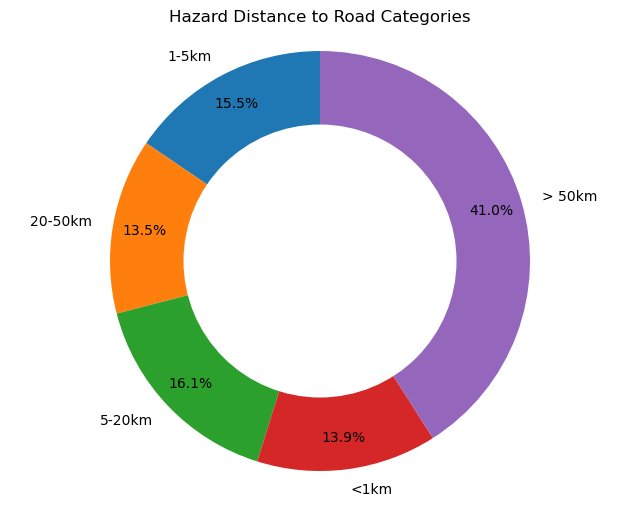

In [39]:
# Categorize distance (in meters)
def classify_distance(m):
    if m < 1000:
        return "<1km"
    elif m < 5000:
        return "1-5km"
    elif m < 20000:
        return "5-20km"
    elif m < 50000:
        return "20-50km"
    else:
        return "> 50km"
# Apply categorization
page3chart["distance_category"] = page3chart["distance"].apply(classify_distance)

# Count each category
distance_counts = page3chart["distance_category"].value_counts().sort_index()

# Plot donut chart
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    distance_counts, 
    labels=distance_counts.index, 
    autopct='%1.1f%%', 
    startangle=90,
    pctdistance=0.85,
    wedgeprops=dict(width=0.4)
)

# Draw circle for donut hole
centre_circle = plt.Circle((0,0),0.65,fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Hazard Distance to Road Categories")

# Save the doughnut chart as a PNG image with high resolution
#plt.savefig(r'D:\NDIS_Database\distance_distribution.png', dpi=300, transparent=True)
plt.show()

In [8]:
import matplotlib.colors as mcolors

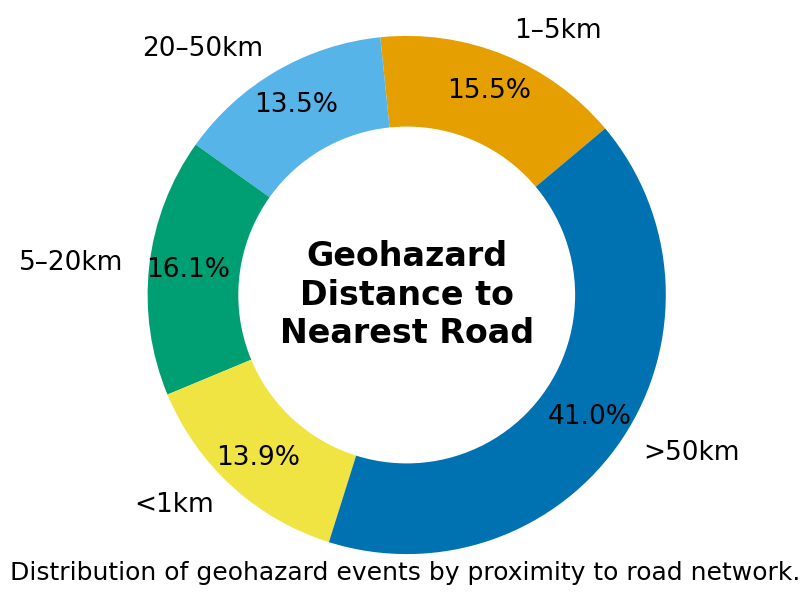

In [39]:
# Categorize distance (in meters)
def classify_distance(m):
    if m < 1000:
        return "<1km"
    elif m < 5000:
        return "1–5km"
    elif m < 20000:
        return "5–20km"
    elif m < 50000:
        return "20–50km"
    else:
        return ">50km"

# Apply categorization
page3chart["distance_category"] = page3chart["distance"].apply(classify_distance)

# Count each category
distance_counts = page3chart["distance_category"].value_counts().sort_index()

# Colorblind-safe palette (Okabe & Ito)
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]

# Normalize for brightness check
def get_text_color(hex_color):
    rgb = mcolors.hex2color(hex_color)
    brightness = np.dot(rgb, [0.299, 0.587, 0.114])  # luminance
    return 'black' if brightness > 0.6 else 'white'

# Plot donut chart
fig, ax = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(top=0.9, bottom=0.2)  # Adjust bottom margin
wedges, texts, autotexts = ax.pie(
    distance_counts,
    labels=distance_counts.index,
    autopct='%1.1f%%',
    startangle=40,
    pctdistance=0.85,
    wedgeprops=dict(width=0.4),
    colors=colors
)

# Adjust text color based on wedge background
for i, autotext in enumerate(autotexts):
    #autotext.set_color(get_text_color(colors[i]))
    autotext.set_fontsize(19)
for t in texts:
    t.set_fontsize(19)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
ax.add_artist(centre_circle)

# Add center title
ax.text(0, 0, "Geohazard\nDistance to\nNearest Road", ha='center', va='center', fontsize=24, weight='bold', color='black')

# Caption below
plt.figtext(0.5, 0.025,
    "Distribution of geohazard events by proximity to road network.",
    wrap=True, horizontalalignment='center', fontsize=18)

ax.axis('equal')
plt.tight_layout()

# Save if needed
plt.savefig(r'D:\NDIS_Database\13_NDIS_Display\Page3\pictures\distance_distribution.png', dpi=300, transparent=True)

plt.show()


In [57]:
rpas_db0524 = pd.read_csv("D:/NDIS_Database/rpas_db0524.csv")
rpas_db0524.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             179 non-null    int64  
 1   country             179 non-null    object 
 2   manufacturer        179 non-null    object 
 3   mfc_model           179 non-null    object 
 4   mtow                157 non-null    float64
 5   length              153 non-null    float64
 6   width               160 non-null    float64
 7   height              135 non-null    float64
 8   max_speed           154 non-null    float64
 9   distance_range      71 non-null     float64
 10  flight_time         165 non-null    float64
 11  max_payload_weight  161 non-null    float64
 12  max_alt             102 non-null    float64
 13  comm_range          118 non-null    float64
 14  power_source        163 non-null    object 
 15  power               111 non-null    object 
 16  gps_accu

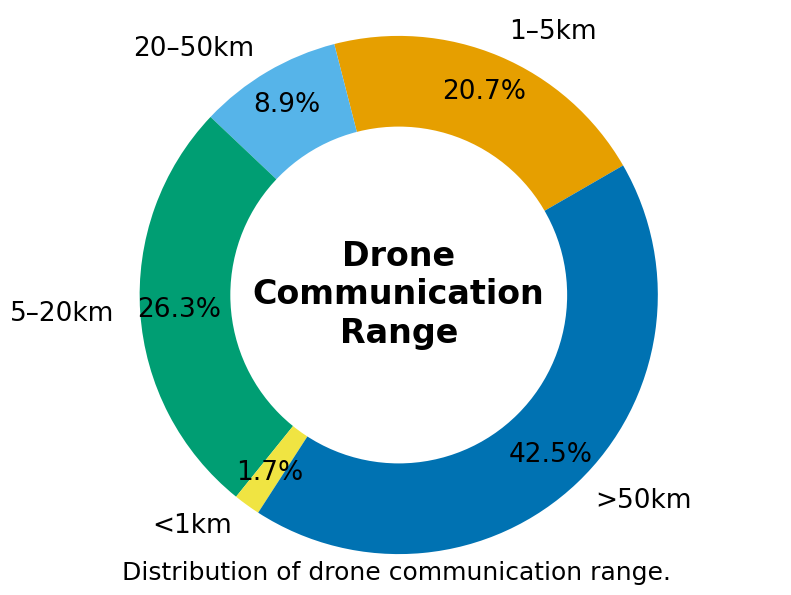

In [5]:
# Categorize distance (in meters)
def classify_comm(m):
    if m < 1000:
        return "<1km"
    elif m < 5000:
        return "1–5km"
    elif m < 20000:
        return "5–20km"
    elif m < 50000:
        return "20–50km"
    else:
        return ">50km"

# Apply categorization
rpas_db0524["comm_category"] = rpas_db0524["comm_range"].apply(classify_comm)

# Count each category
comm_countsr = rpas_db0524["comm_category"].value_counts().sort_index()

# Colorblind-safe palette (Okabe & Ito)
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]

# Normalize for brightness check
def get_text_color(hex_color):
    rgb = mcolors.hex2color(hex_color)
    brightness = np.dot(rgb, [0.299, 0.587, 0.114])  # luminance
    return 'black' if brightness > 0.6 else 'white'

# Plot donut chart
fig, ax = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(top=0.9, bottom=0.2)  # Adjust bottom margin
wedges, texts, autotexts = ax.pie(
    comm_countsr,
    labels=comm_countsr.index,
    autopct='%1.1f%%',
    startangle=30,
    pctdistance=0.85,
    wedgeprops=dict(width=0.4),
    colors=colors
)

# Adjust text color based on wedge background
for i, autotext in enumerate(autotexts):
    #autotext.set_color(get_text_color(colors[i]))
    autotext.set_fontsize(19)
for t in texts:
    t.set_fontsize(19)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
ax.add_artist(centre_circle)

# Add center title
ax.text(0, 0, "Drone\nCommunication\nRange", ha='center', va='center', fontsize=24, weight='bold', color='black')

# Caption below
plt.figtext(0.5, 0.025,
    "Distribution of drone communication range.",
    wrap=True, horizontalalignment='center', fontsize=18)

ax.axis('equal')
plt.tight_layout()

# Save if needed
#plt.savefig(r'D:\NDIS_Database\13_NDIS_Display\Page3\pictures\drone_comm.png', dpi=300, transparent=True)

plt.show()


In [58]:
comm_countsr

comm_category
1–5km      37
20–50km    16
5–20km     47
<1km        3
>50km      76
Name: count, dtype: int64

In [51]:
rpas_db0524 = pd.read_csv("D:/NDIS_Database/rpas_db0524.csv") # Completed version of RPAS gdb with NaN data on distance
rpas_db0524.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             179 non-null    int64  
 1   country             179 non-null    object 
 2   manufacturer        179 non-null    object 
 3   mfc_model           179 non-null    object 
 4   mtow                157 non-null    float64
 5   length              153 non-null    float64
 6   width               160 non-null    float64
 7   height              135 non-null    float64
 8   max_speed           154 non-null    float64
 9   distance_range      71 non-null     float64
 10  flight_time         165 non-null    float64
 11  max_payload_weight  161 non-null    float64
 12  max_alt             102 non-null    float64
 13  comm_range          118 non-null    float64
 14  power_source        163 non-null    object 
 15  power               111 non-null    object 
 16  gps_accu

In [59]:
rpas_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             179 non-null    int64  
 1   manufacturer        179 non-null    object 
 2   mfc_model           179 non-null    object 
 3   distance_range      71 non-null     float64
 4   max_payload_weight  161 non-null    float64
 5   flight_time         165 non-null    float64
 6   comm_range          118 non-null    float64
 7   max_speed           154 non-null    float64
 8   mtow                157 non-null    float64
 9   length              153 non-null    float64
 10  width               160 non-null    float64
 11  height              135 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 16.9+ KB


In [52]:
rpas_db0524.comm_range.unique()

array([2.000e+05, 2.000e+03, 4.000e+03, 8.000e+03, 7.000e+03, 1.500e+04,
       5.000e+03, 1.000e+04, 1.000e+03, 2.000e+04, 3.500e+04, 1.600e+04,
       5.000e+02, 1.000e+05, 5.000e+04,       nan, 3.000e+03, 8.000e+04,
       1.200e+04, 3.000e+02, 1.500e+03, 6.000e+01, 5.000e+05, 3.200e+03,
       4.000e+04, 4.000e+05, 4.500e+04, 3.500e+03, 7.500e+03, 2.250e+04,
       5.954e+03])

In [6]:
# Apply categorization
rpas_db0524["comm_category"] = rpas_db0524["comm_range"].apply(classify_comm)

# Count each category
comm_countsr = rpas_db0524["comm_category"].value_counts().sort_index()
comm_countsr

comm_category
1–5km      37
20–50km    16
5–20km     47
<1km        3
>50km      76
Name: count, dtype: int64

In [18]:
total_points = len(page3chart)
print(f"Total geohazard points: {total_points:,}")


Total geohazard points: 1,931,885


In [8]:
# Categorize drones by max distance
def categorize_drone_weight(weight):
    if weight <= 500:
        return "< 500gr"
    elif weight <= 1000:
        return "500gr – 1kg"
    elif weight <= 2000:
        return "1–2kg"
    elif weight <= 5000:
        return "2–5kg"
    else:
        return "> 5kg"

rpas_db0524["payloadweight_cat"] = rpas_db0524["max_payload_weight"].apply(categorize_drone_weight)

# Count per category
drone_weight_counts = rpas_db0524["payloadweight_cat"].value_counts().sort_index()
drone_weight_counts

payloadweight_cat
1–2kg           7
2–5kg          39
500gr – 1kg    16
< 500gr        45
> 5kg          72
Name: count, dtype: int64

In [ ]:

# Plot donut chart
fig, ax = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(top=0.9, bottom=0.2)  # Adjust bottom margin
wedges, texts, autotexts = ax.pie(
    comm_countsr,
    labels=comm_countsr.index,
    autopct='%1.1f%%',
    startangle=30,
    pctdistance=0.85,
    wedgeprops=dict(width=0.4),
    colors=colors
)

# Adjust text color based on wedge background
for i, autotext in enumerate(autotexts):
    #autotext.set_color(get_text_color(colors[i]))
    autotext.set_fontsize(19)
for t in texts:
    t.set_fontsize(19)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
ax.add_artist(centre_circle)

# Add center title
ax.text(0, 0, "Drone\nCommunication\nRange", ha='center', va='center', fontsize=24, weight='bold', color='black')

# Caption below
plt.figtext(0.5, 0.025,
    "Distribution of drone communication range.",
    wrap=True, horizontalalignment='center', fontsize=18)

ax.axis('equal')
plt.tight_layout()

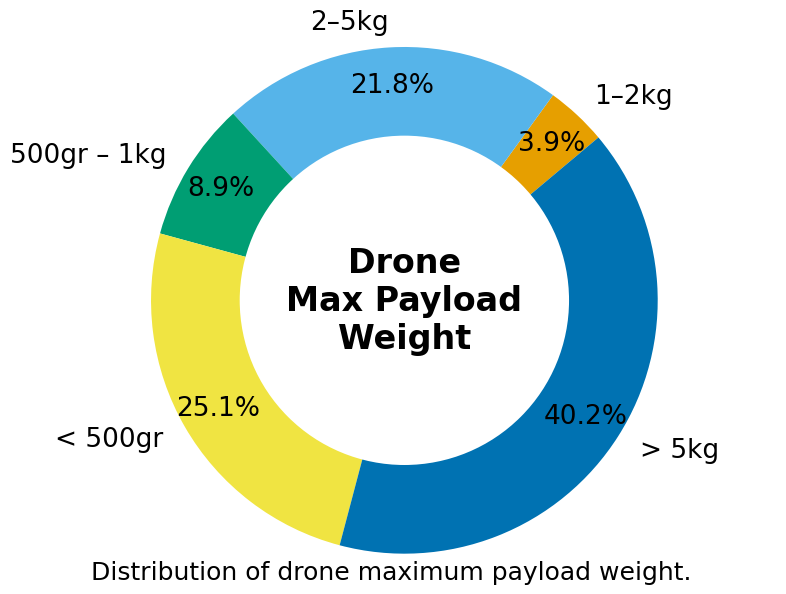

In [9]:
# Colorblind-safe palette (Okabe & Ito)
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]

# Normalize for brightness check
def get_text_color(hex_color):
    rgb = mcolors.hex2color(hex_color)
    brightness = np.dot(rgb, [0.299, 0.587, 0.114])  # luminance
    return 'black' if brightness > 0.6 else 'white'

# Plot donut
fig, ax = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(top=0.9, bottom=0.2)  # Adjust bottom margin
wedges, texts, autotexts = ax.pie(
    drone_weight_counts,
    labels=drone_weight_counts.index,
    autopct='%1.1f%%',
    startangle=40,
    pctdistance=0.85,
    wedgeprops=dict(width=0.4),
    colors=colors
)

# Adjust text color based on wedge background
for i, autotext in enumerate(autotexts):
    #autotext.set_color(get_text_color(colors[i]))
    autotext.set_fontsize(19)
for t in texts:
    t.set_fontsize(19)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
ax.add_artist(centre_circle)

# Add center title
ax.text(0, 0, "Drone\nMax Payload\nWeight", ha='center', va='center', fontsize=24, weight='bold', color='black')

# Caption below
plt.figtext(0.5, 0.025,
    "Distribution of drone maximum payload weight.",
    wrap=True, horizontalalignment='center', fontsize=18)

ax.axis('equal')
plt.tight_layout()

#plt.savefig(r'D:\NDIS_Database\13_NDIS_Display\Page3\pictures\drone_weight.png', dpi=300, transparent=True)

plt.show()

In [76]:
labels

['Earthquake',
 'Fault',
 'Landslide',
 'Nuclear Power Plant',
 'Volcano',
 'Tsunami']

In [105]:
page3chart['HazardType'] = page3chart['HazardType'].replace({'Nuclear': 'Nuclear Power Plant'})

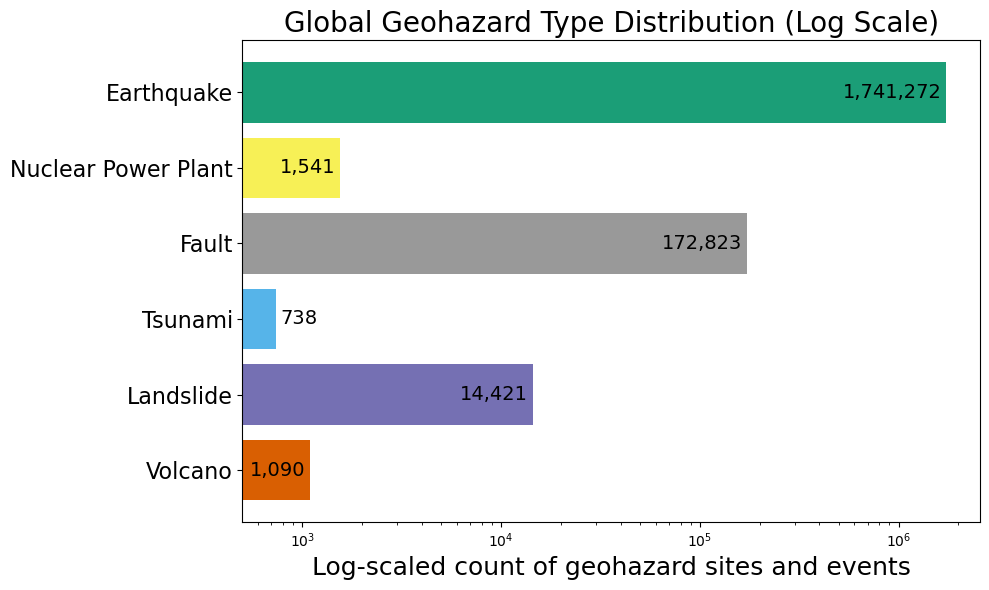

In [138]:
# Define color mapping based on hazard type
hazard_color_map = {
    "Volcano": "#d95f02",             # Orange
    "Earthquake": "#1b9e77",          # Green
    "Landslide": "#7570b3",           # Purple
    "Tsunami": "#56B4E9",             # Sky Blue
    "Fault": "#999999",               # Gray
    "Nuclear Power Plant": "#f7f056"  # Yellow
}
# Count values
hazard_counts = page3chart['HazardType'].value_counts()

# Desired custom order
custom_order = ['Volcano', 'Landslide', 'Tsunami', 'Fault', 'Nuclear Power Plant', 'Earthquake']
# Reindex with custom order
hazard_counts = hazard_counts.reindex(custom_order).fillna(0)

# Color map based on your accessible palette
color_map = {
    'Volcano': '#d95f02',
    'Earthquake': '#1b9e77',
    'Landslide': '#7570b3',
    'Tsunami': '#56B4E9',
    'Fault': '#999999',
    'Nuclear Power Plant': '#f7f056'
}
colors = [color_map.get(h, '#333333') for h in hazard_counts.index]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(hazard_counts.index, hazard_counts.values, color=colors)
ax.set_xscale('log')
ax.set_xlabel("Log-scaled count of geohazard sites and events", fontsize=18)
ax.set_title("Global Geohazard Type Distribution (Log Scale)", fontsize=20)
ax.tick_params(axis='y', labelsize=16)

# Add value labels
#for bar, val in zip(bars, hazard_counts.values):
#    ax.text(val, bar.get_y() + bar.get_height()/2,
#            f'{int(val):,}', va='center', ha='left', fontsize=10)
    
for i, (label, v) in enumerate(zip(hazard_counts.index, hazard_counts.values)):
    if label == 'Tsunami':
        ax.text(v * 1.05, i, f"{v:,}", va='center', ha='left', fontsize=14, color='black')
    else:
        ax.text(v * 0.95, i, f"{v:,}", va='center', ha='right', fontsize=14, color='black')


plt.tight_layout()
plt.savefig(r'D:\NDIS_Database\13_NDIS_Display\Page3\pictures\ghz_type.png', dpi=300, transparent=True)
plt.show()

In [116]:
ordered_labels

['Volcano',
 'Earthquake',
 'Landslide',
 'Tsunami',
 'Fault',
 'Nuclear Power Plant']

In [19]:
hazard_summary.to_csv(r"D:\NDIS_Database\13_NDIS_Display\Page3\hazard_type_summary.csv", index=False)
distance_summary.to_csv(r"D:\NDIS_Database\13_NDIS_Display\Page3\distance_category_summary.csv", index=False)

In [20]:
pop_by_hazard = page3chart.groupby("HazardType")["pop"].sum().reset_index(name="population_at_risk")
pop_by_hazard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HazardType          6 non-null      object 
 1   population_at_risk  6 non-null      float64
dtypes: float64(1), object(1)
memory usage: 228.0+ bytes


In [21]:
total_pop = int(page3chart["pop"].sum())
total_pop

234014939932

In [141]:
# "% of Hazards Near >10,000 People"

In [142]:
threshold = 10000  # or 1e6 for major urban
pop_flag = page3chart.copy()
pop_flag["high_pop"] = pop_flag["pop"] > threshold

hazard_high_pct = (
    pop_flag.groupby("HazardType")["high_pop"]
    .mean()
    .reset_index(name="pct_high_exposure")
)
hazard_high_pct["pct_high_exposure"] *= 100  # convert to percentage

hazard_high_pct

,HazardType,pct_high_exposure
0,Earthquake,36.562410
1,Fault,41.733450
2,Landslide,89.633174
3,Nuclear Power Plant,96.171317
4,Tsunami,43.360434
5,Volcano,52.660550


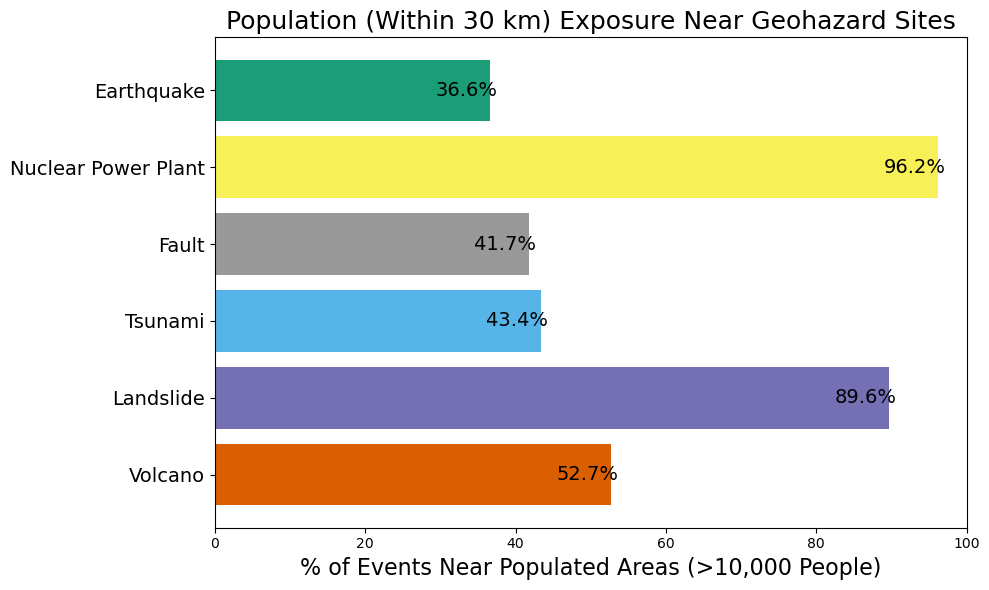

In [148]:
# Hazard Events Within 30 km of Populated Areas (Over 10,000 People)
# Reorder the data to match custom order
custom_order = ['Volcano', 'Landslide', 'Tsunami', 'Fault', 'Nuclear Power Plant', 'Earthquake']
hazard_high_pct = hazard_high_pct.set_index("HazardType").reindex(custom_order).reset_index()

# Color mapping
color_map = {
    "Volcano": "#d95f02",
    "Earthquake": "#1b9e77",
    "Landslide": "#7570b3",
    "Tsunami": "#56B4E9",
    "Fault": "#999999",
    "Nuclear Power Plant": "#f7f056"
}
colors = [color_map[h] for h in hazard_high_pct["HazardType"]]

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(hazard_high_pct["HazardType"], hazard_high_pct["pct_high_exposure"], color=colors)
ax.set_xlabel("% of Events Near Populated Areas (>10,000 People)", fontsize=16)
ax.set_title("Population (Within 30 km) Exposure Near Geohazard Sites", fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim(0, 100)

# Add labels
for i, (label, v) in enumerate(zip(hazard_high_pct["HazardType"], hazard_high_pct["pct_high_exposure"])):
    ax.text(v + 1, i, f"{v:.1f}%", va='center', ha='right', fontsize=14, color='black')

plt.tight_layout()
plt.savefig(r"D:\NDIS_Database\13_NDIS_Display\Page3\pictures\pop_exposure.png", dpi=300, transparent=True)
plt.show()

In [24]:
hazard_high_pct.to_csv(r"D:\NDIS_Database\13_NDIS_Display\Page3\hazard_high_pct.csv", index=False)

# Page 2 Standard version

In [27]:
results372_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   HazardID       int64  
 1   HazardType     object 
 2   Stage          object 
 3   Sensor         object 
 4   FlightPath_m   float64
 5   DroneRank      int64  
 6   DroneModel     object 
 7   PayloadWeight  float64
 8   DistanceRange  int64  
 9   CommRange      float64
 10  FlightTime     float64
dtypes: float64(4), int64(3), object(4)
memory usage: 1.3+ GB


In [ ]:
results372_df.to_csv(r"D:\NDIS_Database\13_NDIS_Display\Page2Layers\result_query.csv", index=False)

In [ ]:
page3chart = results372_df[[
    "HazardID",
    "latitude",
    "longitude",
    "HazardType",
    "distance",
    "pop"
]].copy()
page3chart.info()

In [40]:
ed_only = merged_df_final[(merged_df_final["HazardType"] == "Earthquake")]
ed_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1741272 entries, 15477 to 1902580
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   economic_loss_million  float64
 8   duration_minutes       float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
dtypes: float64(10), int64(1), object(1)
memory usage: 172.7+ MB


In [41]:
ed_only.to_csv(r"D:\NDIS_Database\13_NDIS_Display\Page2Layers\ed_only.csv", index=False)

# Fault

In [16]:
fault_df = merged_df_final[(merged_df_final["HazardType"] == "Fault")]
fault_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172823 entries, 1671180 to 1931884
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   HazardID               172823 non-null  int64  
 1   latitude               172823 non-null  float64
 2   longitude              172823 non-null  float64
 3   HazardType             172823 non-null  object 
 4   distance               143519 non-null  float64
 5   pop                    143519 non-null  float64
 6   intensity              143519 non-null  float64
 7   economic_loss_million  143519 non-null  float64
 8   duration_minutes       143519 non-null  float64
 9   travel_time            142980 non-null  float64
 10  monitor_time           143519 non-null  float64
 11  cpm_total_time         142980 non-null  float64
 12  DroneModel1            143519 non-null  object 
 13  DroneModel2            143519 non-null  object 
 14  DroneModel3            143519 non-

In [18]:
# Drop unwanted columns from ghz_df
fault_df.drop(columns=[
    "DroneModel1", "DroneModel2",
    "DroneModel3", "FlightPath_m1",
    "FlightPath_m2", "FlightPath_m3", "Sensor1",
    "Sensor2", "Sensor3", "Stage_1"
], inplace=True)
fault_df.info()

<class 'KeyError'>: "['DroneModel1', 'DroneModel2', 'DroneModel3', 'FlightPath_m1', 'FlightPath_m2', 'FlightPath_m3', 'Sensor1', 'Sensor2', 'Sensor3', 'Stage_1'] not found in axis"

In [19]:
fault_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172823 entries, 1671180 to 1931884
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   HazardID               172823 non-null  int64  
 1   latitude               172823 non-null  float64
 2   longitude              172823 non-null  float64
 3   HazardType             172823 non-null  object 
 4   distance               143519 non-null  float64
 5   pop                    143519 non-null  float64
 6   intensity              143519 non-null  float64
 7   economic_loss_million  143519 non-null  float64
 8   duration_minutes       143519 non-null  float64
 9   travel_time            142980 non-null  float64
 10  monitor_time           143519 non-null  float64
 11  cpm_total_time         142980 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 17.1+ MB


In [21]:
max(fault_df.HazardID.unique())

1779999951

In [155]:
fault_df.to_csv(r"D:\NDIS_Database\13_NDIS_Display\Page2Layers\fault_only.csv", index=False)